In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/customer-personality-analysis/marketing_campaign.csv


data source: fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

With visualization, I used this notebook's code: https://www.kaggle.com/ludovicocuoghi/plotly-viz-pytorch-neural-net-f1-94-auc-92

In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv", skipinitialspace=True)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score

In [5]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [6]:
df1=df.drop('Cholesterol', axis=1)

It seems that there exists outlier in Resting BP ( zero) 

In [7]:
df2 = df1.drop([449])

In [8]:
df2.iloc[447:450] # well dropped.

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
447,77,M,ASY,124,0,ST,110,Y,2.0,Up,1
448,63,M,ASY,160,1,Normal,105,Y,1.0,Flat,1
450,52,M,NAP,122,0,Normal,110,Y,2.0,Down,1


**Preprocessing**
* Gender: Male=0, Female=1

In [9]:
df2.Sex = df2.Sex.replace({'M':0, 'F':1})

In [10]:
df2.ChestPainType.value_counts()  # similar with table in R
# latter, planning to use dummy coding (one hot encoding)

ASY    496
NAP    202
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [11]:
df2.RestingECG.value_counts() # use dummy coding 

Normal    551
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [12]:
df2.ExerciseAngina = df2.ExerciseAngina.replace({'Y':1, 'N':0})

In [13]:
df2.ST_Slope.value_counts() # use dummy coding

Flat    459
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [14]:
df2.HeartDisease.value_counts() # target

1    507
0    410
Name: HeartDisease, dtype: int64

Target variable is quite well-balanced, and it is binary. In this notebook, classification methods would be used to predict heart failure.

In [15]:
df3 = shuffle(df2)

In [16]:
encdf = pd.get_dummies(df3, drop_first=True)

In [17]:
encdf # shuffled & create dummy variables

,Age,Sex,RestingBP,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
215,30,1,170,0,170,0,0.0,0,0,0,1,0,1,0,1
573,72,0,160,1,130,0,1.5,1,0,0,0,0,0,1,0
24,40,0,130,0,138,0,0.0,0,0,1,0,1,0,0,1
752,56,0,125,1,144,1,1.2,1,0,0,0,0,0,1,0
895,57,0,110,0,143,1,3.0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,59,0,135,0,115,1,1.0,1,0,0,0,1,0,1,0
19,36,0,120,0,160,0,3.0,1,1,0,0,1,0,1,0
504,62,0,158,1,112,1,3.0,1,0,0,0,1,0,0,0
788,68,1,120,0,115,0,1.5,0,0,1,0,0,0,1,0


In [18]:
X = encdf.drop('HeartDisease', axis=1).values

In [19]:
y = encdf['HeartDisease'].values # make x and y as arrays

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [21]:
# standardize 
# fit & transform : https://www.inflearn.com/questions/19038 

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

methods introduced in *Introduction to Statistical Learning(2nd ed) are used.
In today's notebook, I will apply random forest (bagging) & XGboosting

In [22]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

In [23]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame(' ').transpose()
    return scores_df

In [24]:
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_scores(y_test, w_preds)

[13:47:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Precision,Recall,F1,ROC AUC
,0.79,0.81,0.84,0.82,0.78


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

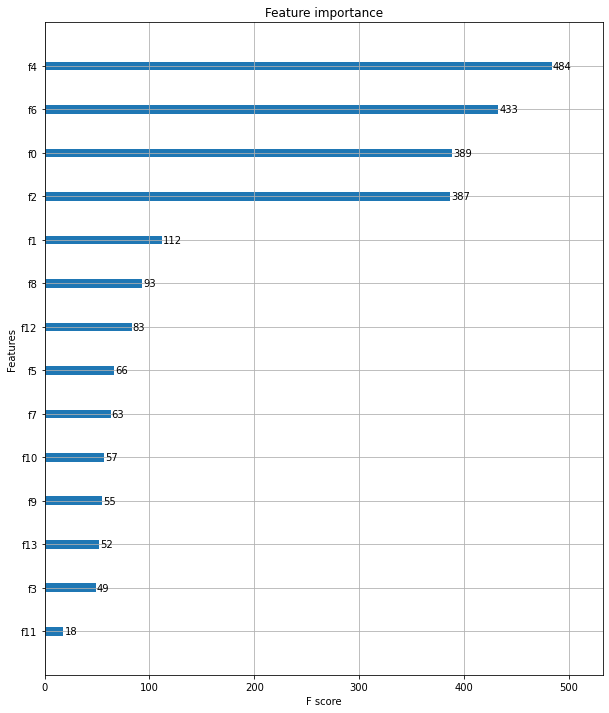

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_wrapper, ax=ax)

In [26]:
df2.head()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,ATA,140,0,Normal,172,0,0.0,Up,0
1,49,1,NAP,160,0,Normal,156,0,1.0,Flat,1
2,37,0,ATA,130,0,ST,98,0,0.0,Up,0
3,48,1,ASY,138,0,Normal,108,1,1.5,Flat,1
4,54,0,NAP,150,0,Normal,122,0,0.0,Up,0


importance: FastingBS > MaxHR > age

### Hyperparameter tuning 
0. Ref: https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
1. general parameters: booster(gbtree, gblinear, dart)
2. booster parameters : tree booster / linear booster (tree always outperforms linear)
  * eta(learning rate in GBM)
  * gamma: specify minimum loss reduction required to make a split (make the algorithm conservative)
  * max_depth : max depth of tree (ctrl for overfitting)
  * min_child_weight
  * max_delta_step: each tree's weight estimation -> 0: no constraint, +: more conservative. (useful when the data is imbalanced)
  * subsample: subsampling rate
  * lambda: L2 regularization term (handle the regularization part of XGboost)
  * alpha: L1 regularization term, useful with high dimension data (handle the regularization part of XGboost)
  * tree_method: approx, hist, gpu_hist
  * scale_pos_weight: controls the balaance of positive & negative weights. 
  * max_leaves
  
3. learning task parameters
  * objective: defines the loss function 
  * eval_metric : metric used for validation data -> default according to loss function 
      * rmse, mae, logloss, error, merror, mlogloss, auc, aucpr
  * seed (random number)
  

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': [0.03, 0.05, 0.07], 
              'max_depth': [6, 8, 10],
              'min_child_weight': [7, 9, 11],
              'subsample': [0.5, 0.7, 0.9],
              'colsample_bytree': [0.5, 0.7, 0.9],
              'n_estimators': [50],
              'seed': [122]}

clf = GridSearchCV(xgb_model, param_grid=parameters,  
                   scoring='roc_auc',
                   verbose=1, refit=True)

In [29]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:   40.5s finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                        

In [30]:
bestpar = clf.best_params_

In [31]:
pred = clf.predict(X_test)
get_scores(y_test, pred)

,Accuracy,Precision,Recall,F1,ROC AUC
,0.81,0.82,0.86,0.84,0.8


In [32]:
y_train.shape

(641,)